In [2]:
# Load the Mall Customers dataset directly from your Colab file path
import pandas as pd

# 🔥 Replace this path with the one you copied from Colab (right-click file → "Copy path")
csv_path = '/content/Mall_Customers.csv'

# Read the CSV
df = pd.read_csv(csv_path)

# Confirm successful load
print("✅ Dataset loaded successfully from:", csv_path)
print(df.head())


✅ Dataset loaded successfully from: /content/Mall_Customers.csv
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


✅ Dataset loaded from: /content/Mall_Customers.csv


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Using columns: 'Annual Income (k$)' (x) and 'Spending Score (1-100)' (y) for clustering.


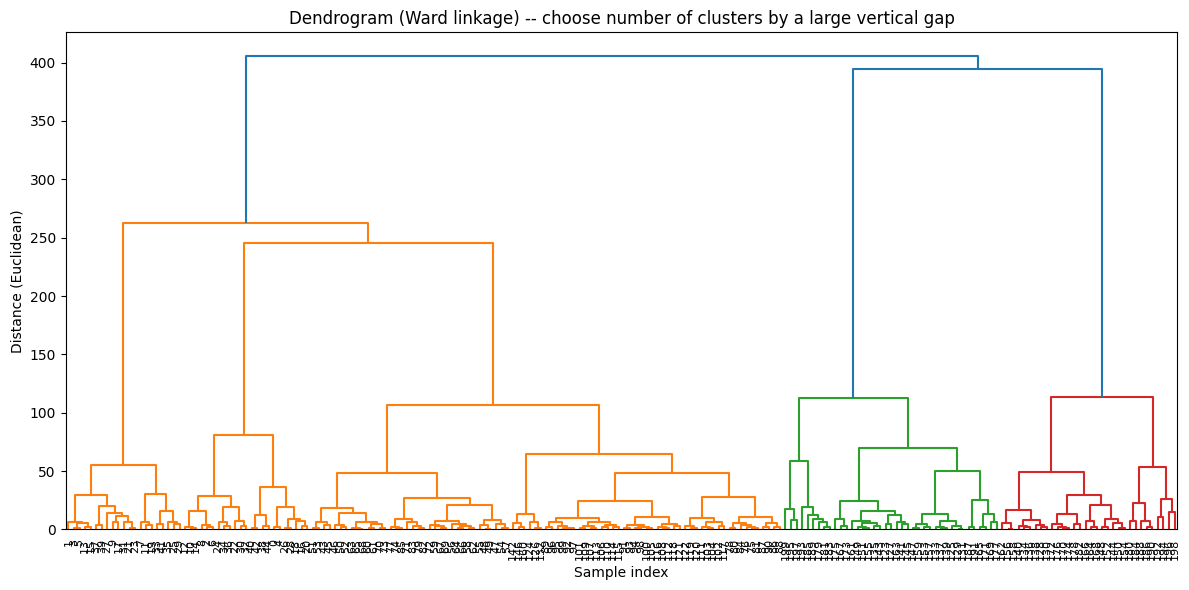


Silhouette scores (2..8):
  n_clusters=2 -> silhouette = 0.3671
  n_clusters=3 -> silhouette = 0.4618
  n_clusters=4 -> silhouette = 0.4917
  n_clusters=5 -> silhouette = 0.5530
  n_clusters=6 -> silhouette = 0.5380
  n_clusters=7 -> silhouette = 0.5199
  n_clusters=8 -> silhouette = 0.4326

Silhouette suggests best n_clusters = 5 (score=0.5530).

Using final_n_clusters = 5 (change this variable if needed).


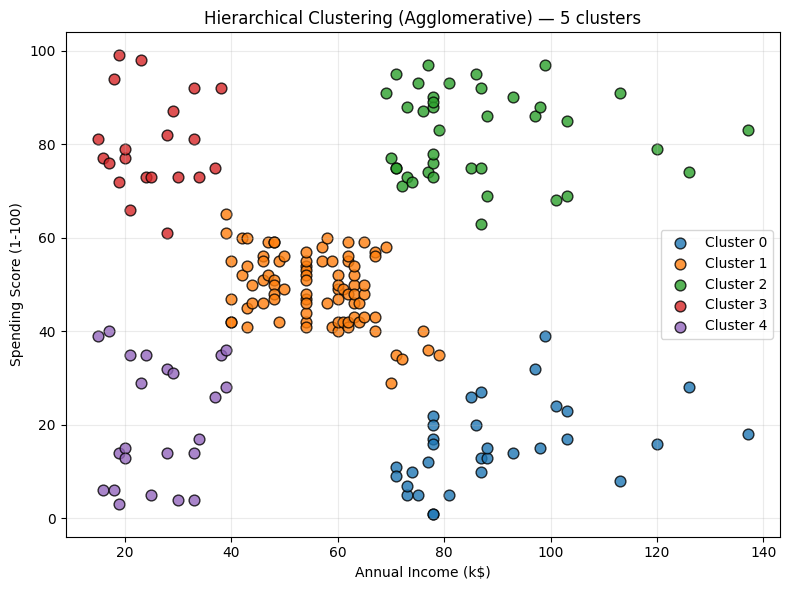


Cluster profiles (mean & count):


Annual Income (k$)       Spending Score (1-100)      
                      mean count                   mean count
Cluster                                                      
0                    89.41    32                  15.59    32
1                    55.81    85                  49.13    85
2                    86.54    39                  82.13    39
3                    25.10    21                  80.05    21
4                    26.30    23                  20.91    23


Cluster sizes:
Cluster
0    32
1    85
2    39
3    21
4    23
Name: count, dtype: int64

Saved clustered results to 'clustered_output.csv' in Colab working dir (/content).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Notes (direct):
- Inspect the dendrogram: pick cluster count where a vertical gap is largest.
- Silhouette gives numeric guidance; prefer interpretability for business segmentation.
- To change clusters, edit 'final_n_clusters' above and re-run the cell.


In [3]:
# Full Hierarchical Clustering pipeline for Mall_Customers.csv (Colab-ready)
# 1) Set csv_path to the path you copied from Colab files panel (eg '/content/Mall_Customers.csv')
# 2) Run the cell — it will show dendrogram, silhouette scores, final cluster plot, profiles and export CSV.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from google.colab import files
import os

# ========= USER: set this to your copied Colab path =========
csv_path = '/content/Mall_Customers.csv'   # <- change if your copied path is different
# ===========================================================

# --- Load dataset ---
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}. Copy path from Colab Files panel and set csv_path accordingly.")
df = pd.read_csv(csv_path)
print("✅ Dataset loaded from:", csv_path)
display(df.head())

# --- Robust feature selection for Annual Income and Spending Score ---
income_candidates = [c for c in df.columns if 'income' in c.lower()]
spend_candidates = [c for c in df.columns if ('spend' in c.lower() or 'score' in c.lower())]

if income_candidates and spend_candidates:
    income_col = income_candidates[0]
    spend_col = spend_candidates[0]
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) >= 2:
        income_col, spend_col = numeric_cols[0], numeric_cols[1]
    else:
        raise ValueError("Could not detect suitable columns. Ensure CSV has 'Annual Income' and 'Spending Score' numeric columns.")

print(f"\nUsing columns: '{income_col}' (x) and '{spend_col}' (y) for clustering.")
X = df[[income_col, spend_col]].values

# --- Basic cleaning: drop rows with missing features ---
mask = ~np.isnan(X).any(axis=1)
if mask.sum() != X.shape[0]:
    print(f"Dropping {X.shape[0]-mask.sum()} rows with NaN in the two features.")
X = X[mask]
df = df.loc[mask].reset_index(drop=True)

# --- 1) Dendrogram (Ward linkage) ---
plt.figure(figsize=(12, 6))
Z = linkage(X, method='ward')   # ward uses euclidean internally
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.title('Dendrogram (Ward linkage) -- choose number of clusters by a large vertical gap')
plt.xlabel('Sample index')
plt.ylabel('Distance (Euclidean)')
plt.tight_layout()
plt.show()

# --- 2) Silhouette guidance for cluster counts 2..8 ---
print("\nSilhouette scores (2..8):")
sil_scores = {}
for k in range(2, 9):
    model_k = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_k = model_k.fit_predict(X)
    try:
        s = silhouette_score(X, labels_k)
    except Exception:
        s = float('nan')
    sil_scores[k] = s
    print(f"  n_clusters={k} -> silhouette = {s:.4f}")

best_k = max(sil_scores, key=lambda k: sil_scores[k] if not np.isnan(sil_scores[k]) else -999)
print(f"\nSilhouette suggests best n_clusters = {best_k} (score={sil_scores[best_k]:.4f}).")

# --- 3) Final clustering: choose n_clusters below ---
# If your instructor expects exactly 5 clusters set final_n_clusters = 5.
final_n_clusters = 5   # <--- change to best_k or any number you want (e.g., best_k)
print(f"\nUsing final_n_clusters = {final_n_clusters} (change this variable if needed).")

model = AgglomerativeClustering(n_clusters=final_n_clusters, linkage='ward')
cluster_labels = model.fit_predict(X)
df['Cluster'] = cluster_labels

# --- 4) Plot clusters ---
plt.figure(figsize=(8,6))
for label in np.unique(cluster_labels):
    mask = cluster_labels == label
    plt.scatter(X[mask, 0], X[mask, 1], label=f"Cluster {label}", s=60, alpha=0.8, edgecolors='k')
plt.title(f'Hierarchical Clustering (Agglomerative) — {final_n_clusters} clusters')
plt.xlabel(income_col)
plt.ylabel(spend_col)
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# --- 5) Cluster profiles (means, counts) ---
profile = df.groupby('Cluster')[[income_col, spend_col]].agg(['mean','count']).round(2)
print("\nCluster profiles (mean & count):")
display(profile)

print("\nCluster sizes:")
print(df['Cluster'].value_counts().sort_index())

# --- 6) Export results ---
outname = 'clustered_output.csv'
df.to_csv(outname, index=False)
print(f"\nSaved clustered results to '{outname}' in Colab working dir (/content).")

# Attempt automatic download (works in many Colab setups)
try:
    files.download(outname)
except Exception:
    print("Automatic download failed or blocked — use Colab Files panel to download 'clustered_output.csv' manually.")

# --- Helpful direct notes (no fluff) ---
print("\nNotes (direct):")
print("- Inspect the dendrogram: pick cluster count where a vertical gap is largest.")
print("- Silhouette gives numeric guidance; prefer interpretability for business segmentation.")
print("- To change clusters, edit 'final_n_clusters' above and re-run the cell.")
